In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 25.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
import mne
from mne import io

In [ ]:
def find_seizures(binary_predictions, max_len):
  # take in the list
  # take max_seizure length - arbitrary - need to optimize 
  # 
  # initialize count and index start monitors
  counts = []
  index_at_seizure_start = []
  index_at_seizure_end = []
  length = 0

  while length < max_len:
    
    # initialiez count, switch and iterator j
    count = 1
    switch = True
    j = 1
  
    if binary_predictions[length] == 1:

      # count consecutive ones: 
      while switch == True:
        if length+j < max_len:

          if binary_predictions[length+j] == 1:
            count += 1
            j += 1
          elif binary_predictions[length+j] == 0:
            ending_j = length + j - 1
            index_at_seizure_end.append(ending_j)
            break
        
        else:
          break

      
      counts.append(count)
      index_at_seizure_start.append(length)
      # print(length)
      # print(j)

      length = length + j
      # print(length)
      # print(j)

    else:
      length +=1
  

  # If final seizure till the end:
  if len(index_at_seizure_start) == len(index_at_seizure_end):
    pass
  
  elif len(index_at_seizure_start) == len(index_at_seizure_end) + 1:
    index_at_seizure_end.append(max_len)

  else:
    print("ANOTHER INDEXING ISSUE WITH FINDING SEIZURES")
  
  return counts, index_at_seizure_start, index_at_seizure_end

In [ ]:
def vectorized_stride(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1

    sub_windows = (
            start +
            np.expand_dims(np.arange(sub_window_size), 0) +
            # Create a rightmost vector as [0, V, 2V, ...].
            np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )

    return array[sub_windows]

In [ ]:
def filter_sequence(sequence, patient_data):
  # ISEK recommendations for surface EMG: high pass with 5 Hz cut off, low pass with 500 Hz cutoff.
  # https://www1.udel.edu/biology/rosewc/kaap686/notes/EMG%20analysis.pdf
  # 30 Hz was optimal high pass cutoff frequency 
  # High-pass filtering to remove electrocardiographic interference from torso EMG recordings PAPER


  lower_sampling = ['train025','train127', 'train163', 'train198', 'train203']

  lower_freq = 250

  higher_sampling = ['train177', 'train226', 'train178', 'train307', 'train256', 'train275',
                      'train291', 'train276', 'train353', 'train349', 'train357']
  higher_freq = 256

  truncated_name = patient_data[:8]

  notch_freqs = np.arange(50, 100)

  if truncated_name in lower_sampling:
    sequence = mne.filter.notch_filter(x = sequence, Fs = lower_freq, freqs = 50, method = 'iir', iir_params = None, verbose = 0)
    sequence = mne.filter.notch_filter(x = sequence, Fs = lower_freq, freqs = 100, method = 'iir', iir_params = None, verbose = 0)
    
    filtered_sequence =  mne.filter.filter_data(data = sequence, sfreq = lower_freq, l_freq = 10, h_freq = None, method='iir', iir_params = None, verbose = 0)
    # dict(order=4, ftype='butter', output='sos')
    
    # print("250 Hz sampling rate")
    
  
  elif truncated_name in higher_sampling:
    
    sequence = mne.filter.notch_filter(x = sequence, Fs = higher_freq, freqs = 50, method = 'iir', iir_params = None, verbose = 0)
    sequence = mne.filter.notch_filter(x = sequence, Fs = higher_freq, freqs = 100, method = 'iir', iir_params = None, verbose = 0)
    filtered_sequence =  mne.filter.filter_data(data = sequence, sfreq = higher_freq, l_freq = 10, h_freq = None, method='iir', iir_params = None, verbose = 0)
    
    # print("256 Hz sampling rate")
    
  else: 
    pass

  return filtered_sequence

In [ ]:
def segmentor_test(subject):

  # ros_test = RandomOverSampler(sampling_strategy=1.0, random_state=None)
  # test array placeholder
  testX = np.empty(shape=[0])
  # test label array placeholder
  testY = np.empty(shape=[0])


  print("Current subject:", subject)
  subj_array = np.load('/content/drive/MyDrive/Colab Notebooks/patient_arrays/{}'.format(subject))
  # Get data to single arrays
  x_subj = subj_array[:, 0]
  y_subj = subj_array[:, 1]
  # x_subj = filter_sequence(x_subj, subject[i])

  testX = np.concatenate((testX, x_subj), axis = 0)
  testY = np.concatenate((testY, y_subj), axis = 0)

  testX = filter_sequence(testX, subject)

  #testX = (testX-np.amin(testX))/(np.amax(testX) - np.amin(testX))
  




  # extract length of recording
  #length = np.size(test_data_std)
  #recording_length = int(length - 1)
  '''

  # plt.plot(test_Y)
  # slice up training data
  x_test_sliced = vectorized_stride(test_data_std, 1, max_time=recording_length, sub_window_size=1000,
                                       stride_size=1000)
  # slice up the label data
  y_test_sliced = vectorized_stride(testY, 1, max_time=recording_length, sub_window_size=1000,
                                       stride_size=1000)
  
  # touch up the label array (tuple to single value)
  rows, columns = np.shape(y_test_sliced)

  y_data = np.zeros(rows)
  # iterate through rows:
  for i in range(0, rows):
      # iterate through row
      if any(y_test_sliced[i]) == 1:
        # print("Seizure")
        y_data[i] = 1
      else:
        continue
  '''
  return testX, testY
  #return x_test_sliced, y_data.astype(int), y_test_sliced

In [ ]:
all_seizures_data = [
'train025_r2.npy',
'train163_r1.npy',
'train177_r4.npy',
'train178_r4.npy',
'train198_r2.npy',
'train203_r8.npy',
'train226_r6.npy',
'train256_r12.npy',
'train256_r14.npy',
'train275_r29.npy',
'train275_r31.npy',
'train276_r5.npy',
'train276_r8.npy',
'train276_r39.npy',
'train291_r15.npy',
'train291_r16.npy',
'train291_r21.npy',
'train291_r23.npy',
'train291_r25.npy',
'train291_r26.npy',
'train307_r1.npy',
'train349_r3.npy',
'train353_r1.npy',
'train353_r6.npy',
'train357_r45.npy',
'train357_r58.npy'
]

In [ ]:
def get_fs(rec_name):
  truncated_name = rec_name[:8]
  lower_sampling = ['train025','train127', 'train163', 'train198', 'train203']

  lower_freq = 250
  higher_freq = 256
  higher_sampling = ['train177', 'train226', 'train178', 'train307', 'train256', 'train275',
                          'train291', 'train276', 'train353', 'train349', 'train357']

  if truncated_name in lower_sampling:
    return_sampling_rate = lower_freq
    
  
  elif truncated_name in higher_sampling:
    
    return_sampling_rate = higher_freq
    
  else: 
    print("NOT FOUND")
    pass
  
  return return_sampling_rate

                          



In [ ]:
all_subjects = ['train025_r2.npy','train163_r1.npy','train177_r4.npy','train178_r4.npy','train198_r2.npy','train203_r8.npy',
'train226_r6.npy','train256_r12.npy','train256_r14.npy','train275_r29.npy','train275_r31.npy','train276_r5.npy','train276_r8.npy',
'train276_r39.npy','train291_r15.npy','train291_r16.npy','train291_r21.npy','train291_r23.npy','train291_r25.npy','train291_r26.npy',
'train307_r1.npy','train349_r3.npy','train353_r1.npy','train353_r6.npy','train357_r45.npy','train357_r58.npy']



names = [
'SUBJ-1a-025',
'SUBJ-1a-163',
'SUBJ-1a-177',
'SUBJ-1b-178',
'SUBJ-4-198',
'SUBJ-4-203',
'SUBJ-1a-226',
'SUBJ-6-256',
'SUBJ-6-256',
'SUBJ-6-275',
'SUBJ-6-275',
'SUBJ-6-275',
'SUBJ-6-275',
'SUBJ-6-275',
'SUBJ-6-276',
'SUBJ-6-291',
'SUBJ-6-291',
'SUBJ-6-291',
'SUBJ-6-291',
'SUBJ-6-291',
'SUBJ-6-291',
'SUBJ-1b-307', 
'SUBJ-1a-349',
'SUBJ-1a-353',
'SUBJ-1a-353',
'SUBJ-6-357'
'SUBJ-6-357']


In [ ]:
target = all_subjects

In [ ]:
from scipy.fft import rfft, rfftfreq

In [ ]:
def visualize_frequencies(xf, yf, name):

  print("Name: ", name)
  plt.plot(xf, abs(yf), color = 'k',alpha = 0.85)
  plt.title("{} Seizure Frequency Power Spectrum".format(name), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power Spectral Density '+r'$[μV^2]$')
  #plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()

  start_10 = np.where(xf >= 10)
  end_70 = np.where(xf <= 70)
  start_10 = int(start_10[0][0])
  end_70 = int(end_70[0][-1])



  plt.plot(xf[start_10:end_70], abs(yf[start_10:end_70]), color = 'k',alpha = 0.85)
  plt.title("{} Seizure Frequency Power Spectrum".format(name), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power Spectral Density '+r'$[μV^2]$')
  #plt.legend(['Freq Spectrum 2'], loc='upper left')
  plt.show()

  return True

In [ ]:
def segmentor_test(subject):

  # ros_test = RandomOverSampler(sampling_strategy=1.0, random_state=None)
  # test array placeholder
  testX = np.empty(shape=[0])
  # test label array placeholder
  testY = np.empty(shape=[0])


  print("Current subject:", subject)
  subj_array = np.load('/content/drive/MyDrive/Colab Notebooks/patient_arrays/{}'.format(subject))
  # Get data to single arrays
  x_subj = subj_array[:, 0]
  y_subj = subj_array[:, 1]
  # x_subj = filter_sequence(x_subj, subject[i])

  testX = np.concatenate((testX, x_subj), axis = 0)
  testY = np.concatenate((testY, y_subj), axis = 0)

  testX = filter_sequence(testX, subject)

  #testX = (testX- testX.mean())/testX.std()
  
  return testX, testY

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train025_r2.npy
Current subject: train025_r2.npy


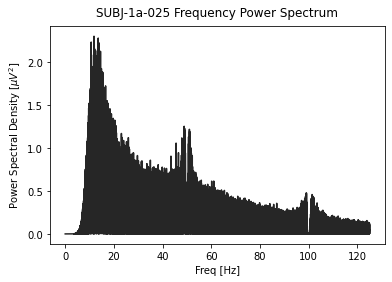

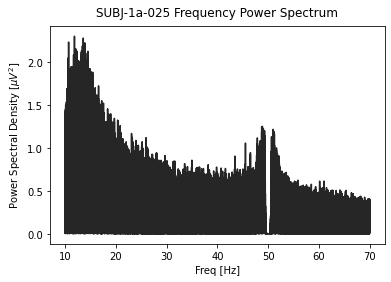

[27000]
[17524000]
[17550999]


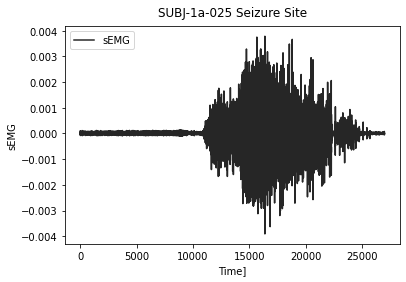

Name:  SUBJ-1a-025


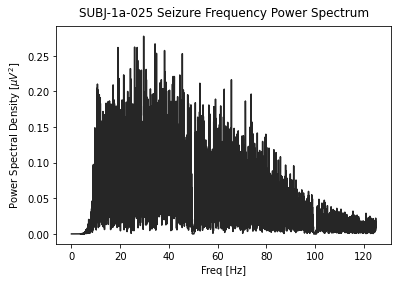

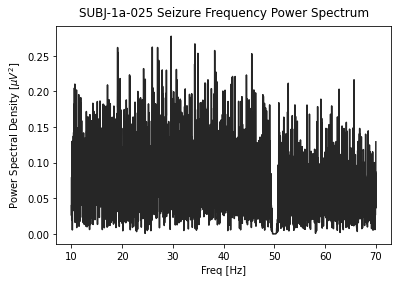

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train163_r1.npy
Current subject: train163_r1.npy


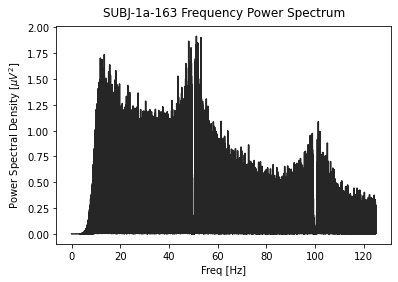

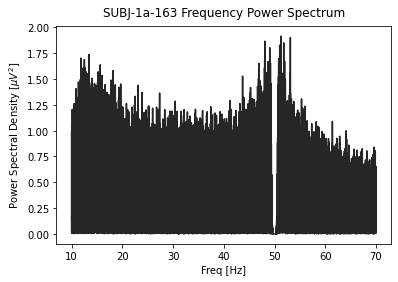

[33500]
[5331500]
[5364999]


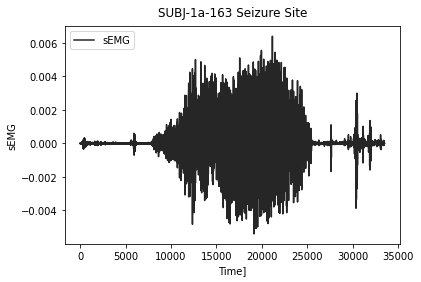

Name:  SUBJ-1a-163


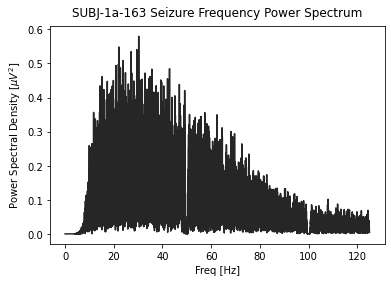

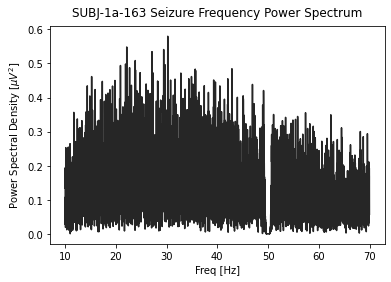

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train177_r4.npy
Current subject: train177_r4.npy


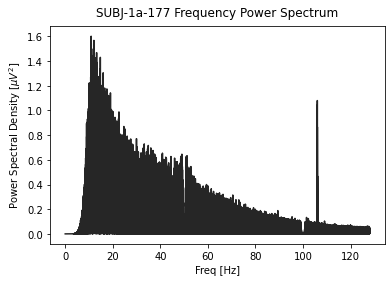

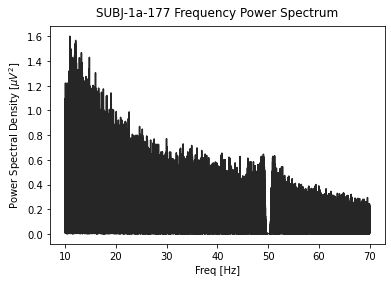

[33792]
[8652800]
[8686591]


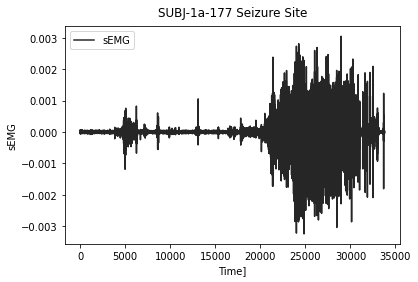

Name:  SUBJ-1a-177


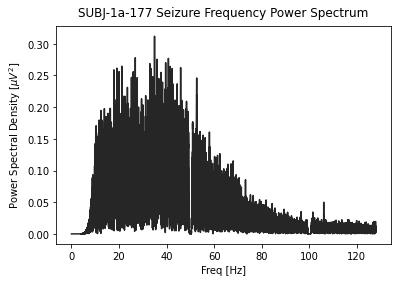

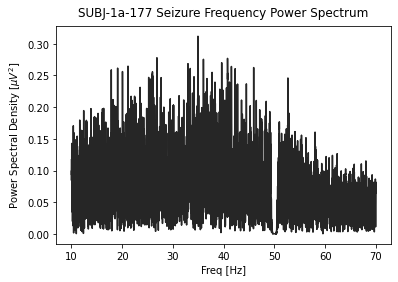

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train178_r4.npy
Current subject: train178_r4.npy


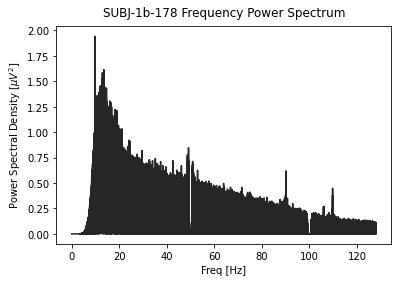

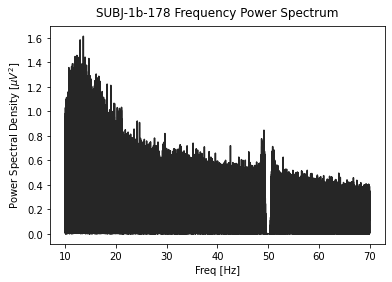

[28672]
[16243968]
[16272639]


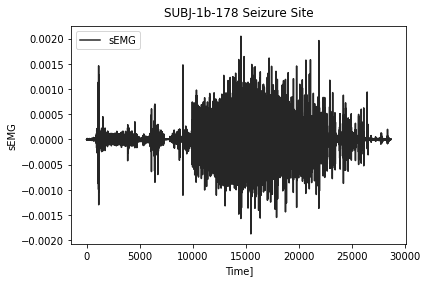

Name:  SUBJ-1b-178


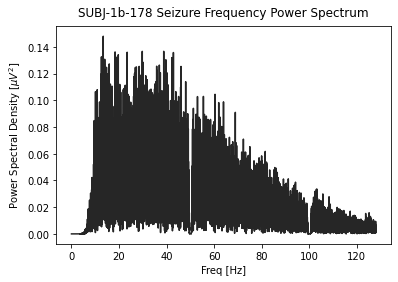

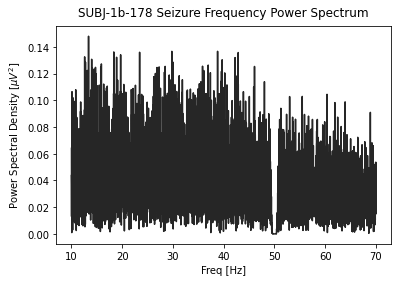

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train198_r2.npy
Current subject: train198_r2.npy


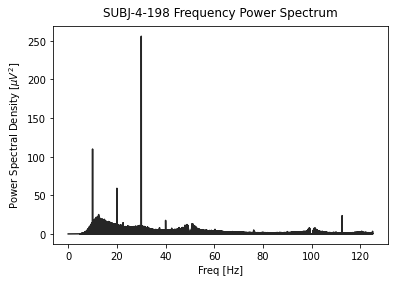

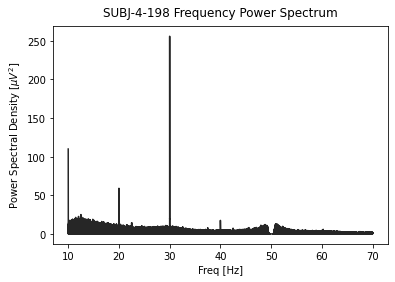

[16500]
[12646750]
[12663249]


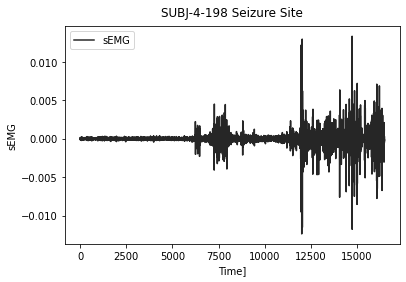

Name:  SUBJ-4-198


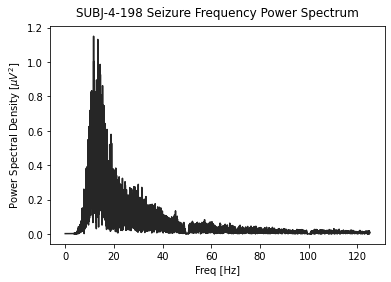

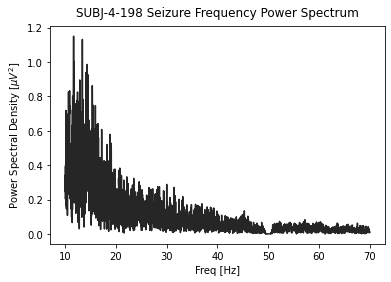

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train203_r8.npy
Current subject: train203_r8.npy


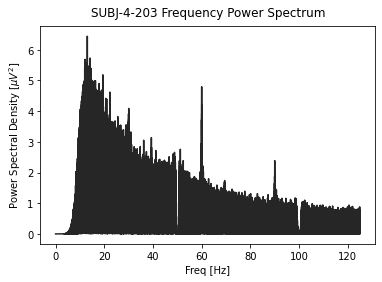

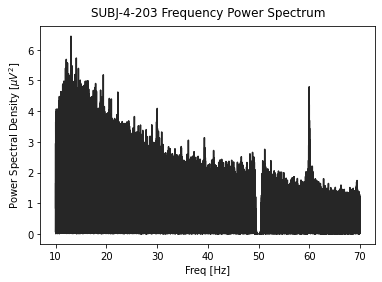

[22250, 22250]
[882750, 4671000]
[904999, 4693249]


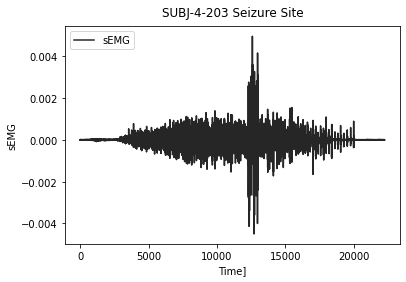

Name:  SUBJ-4-203


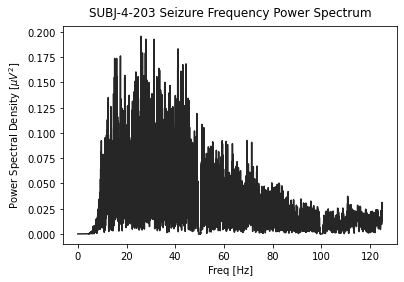

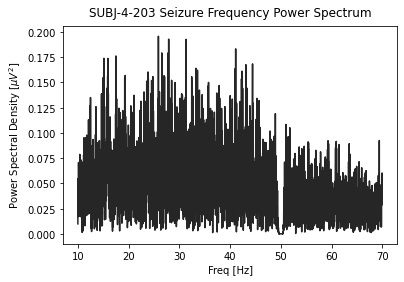

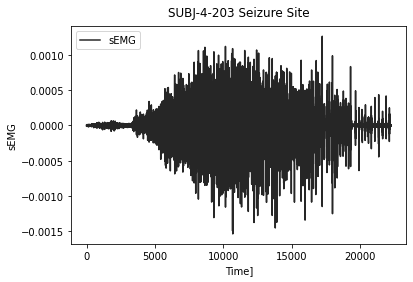

Name:  SUBJ-4-203


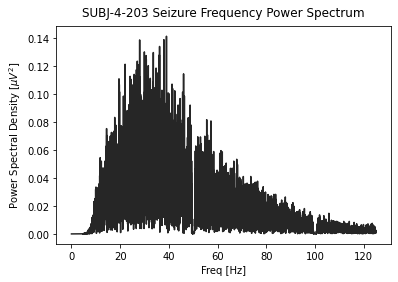

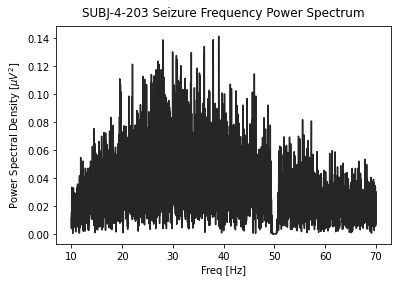

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train226_r6.npy
Current subject: train226_r6.npy


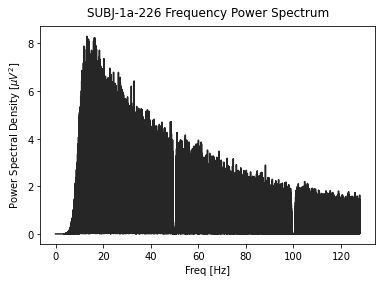

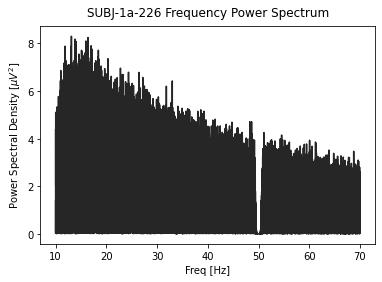

[18432]
[5808640]
[5827071]


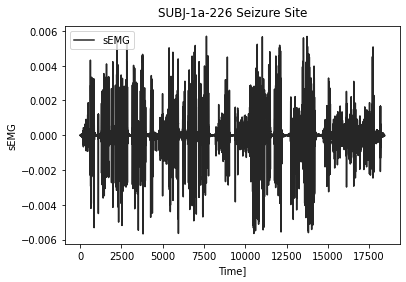

Name:  SUBJ-1a-226


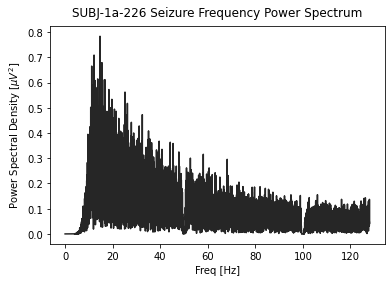

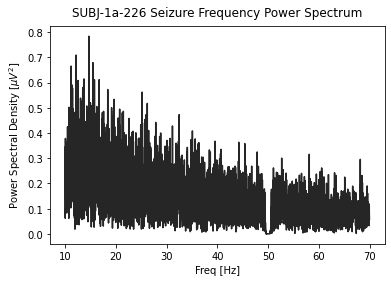

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train256_r12.npy
Current subject: train256_r12.npy


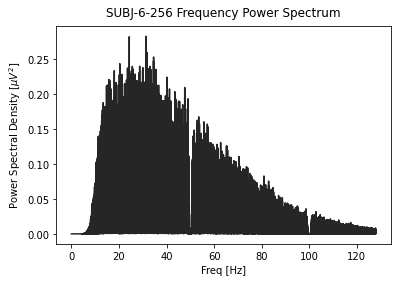

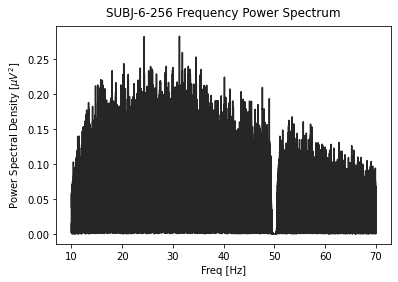

[24320]
[4652032]
[4676351]


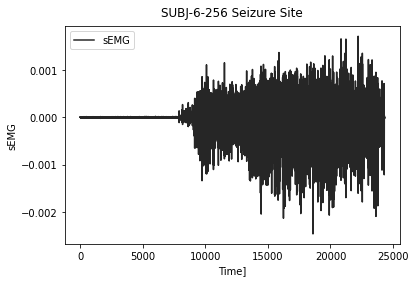

Name:  SUBJ-6-256


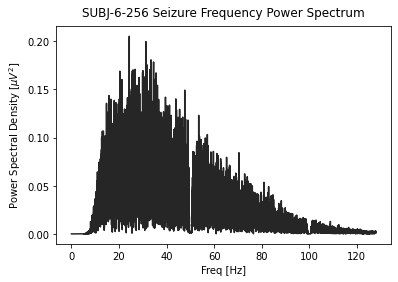

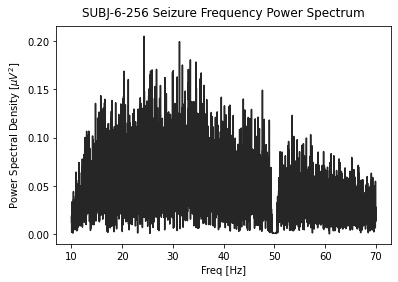

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train256_r14.npy
Current subject: train256_r14.npy


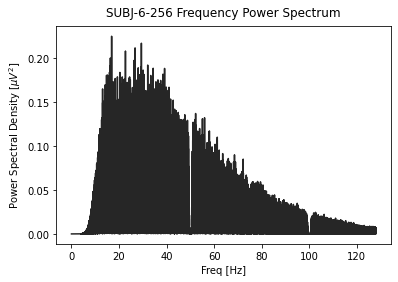

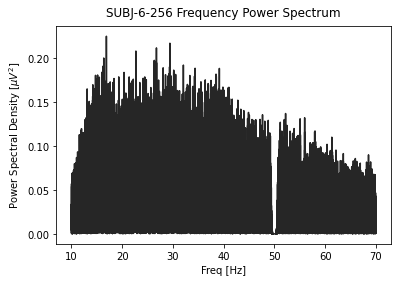

[25344]
[148736]
[174079]


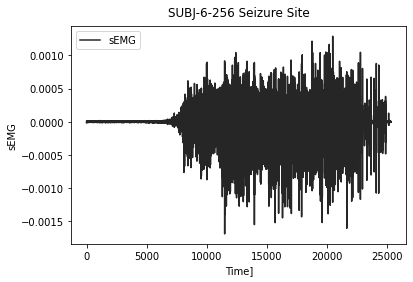

Name:  SUBJ-6-256


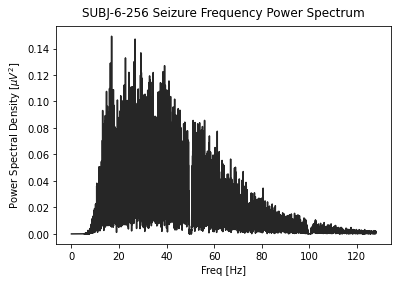

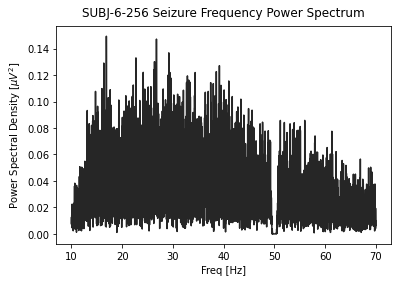

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train275_r29.npy
Current subject: train275_r29.npy


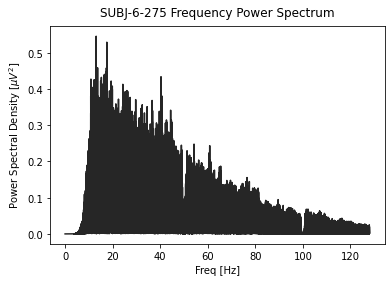

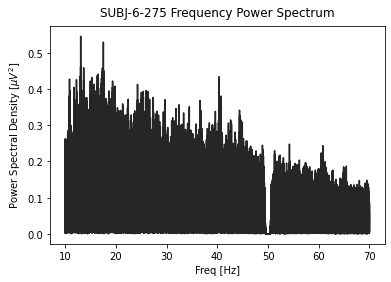

[36864]
[563456]
[600319]


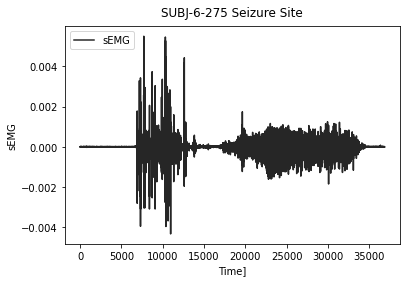

Name:  SUBJ-6-275


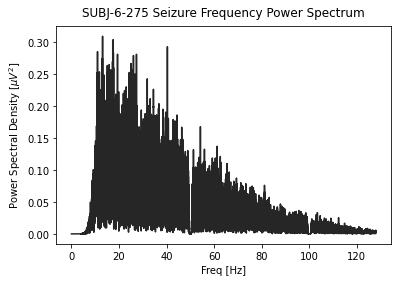

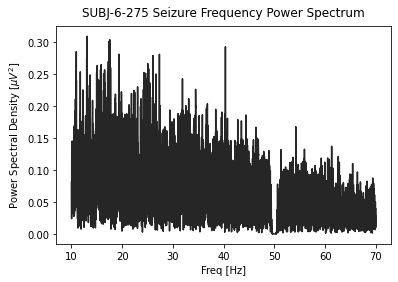

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train275_r31.npy
Current subject: train275_r31.npy


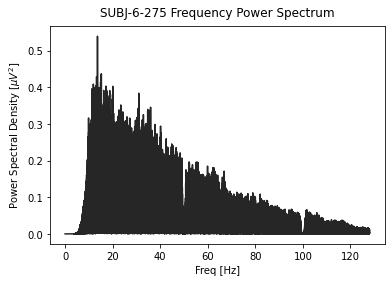

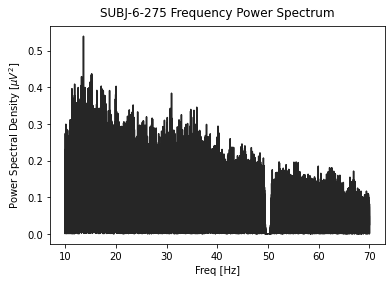

[37376]
[2551296]
[2588671]


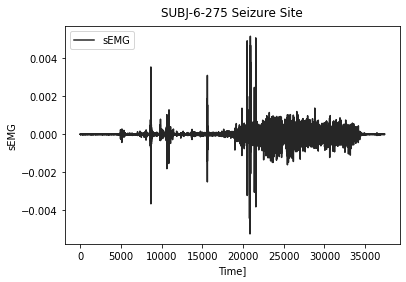

Name:  SUBJ-6-275


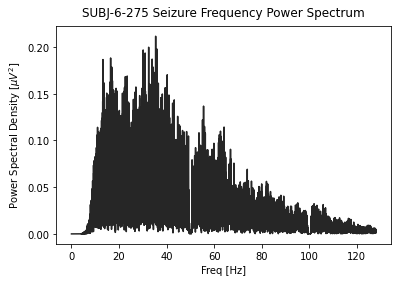

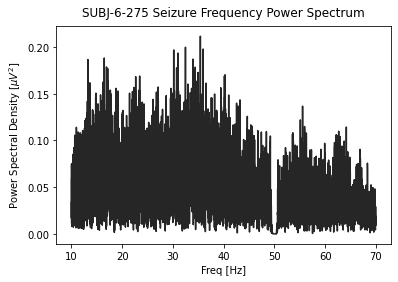

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train276_r5.npy
Current subject: train276_r5.npy


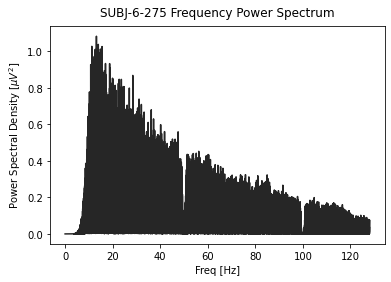

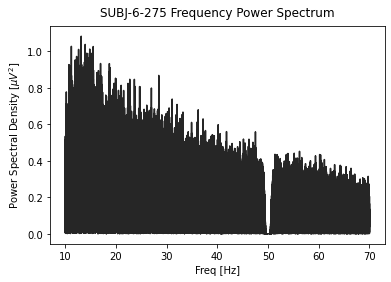

[42752]
[4930304]
[4973055]


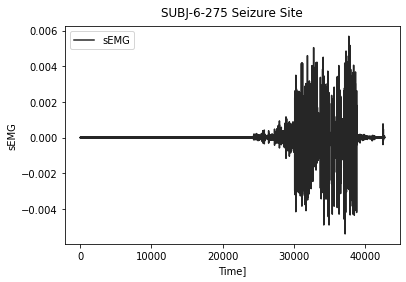

Name:  SUBJ-6-275


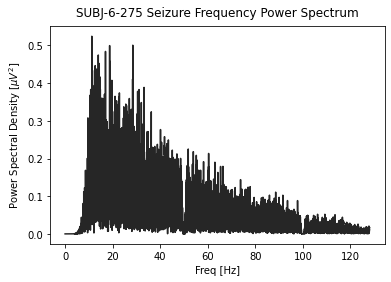

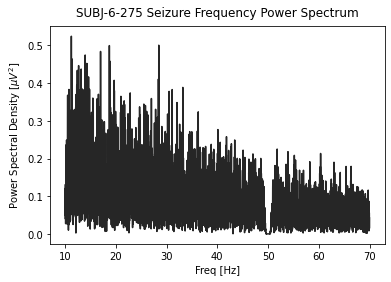

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train276_r8.npy
Current subject: train276_r8.npy


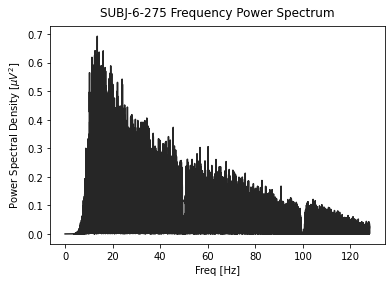

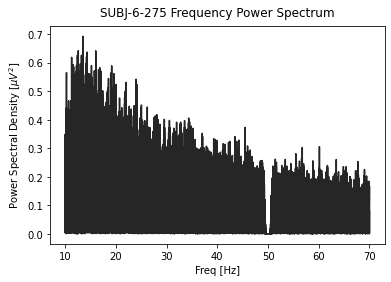

[22272]
[4858624]
[4880895]


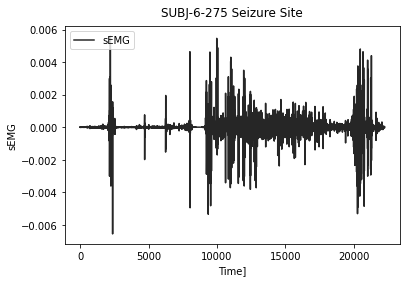

Name:  SUBJ-6-275


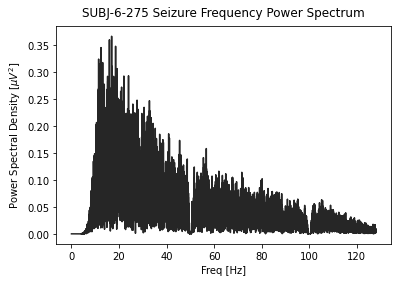

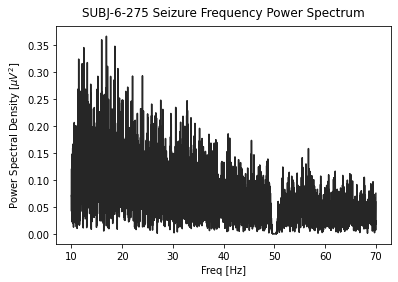

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train276_r39.npy
Current subject: train276_r39.npy


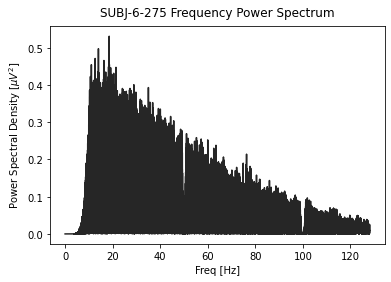

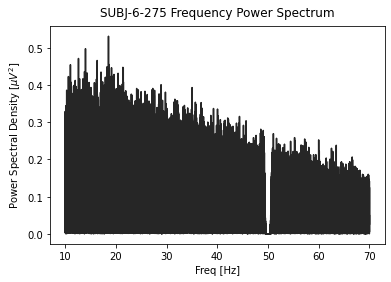

[19456]
[5341184]
[5360639]


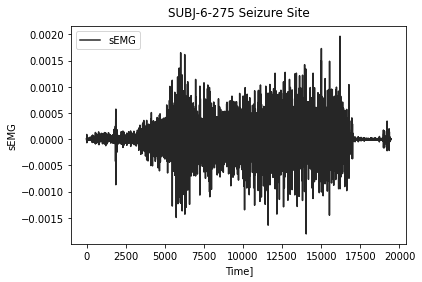

Name:  SUBJ-6-275


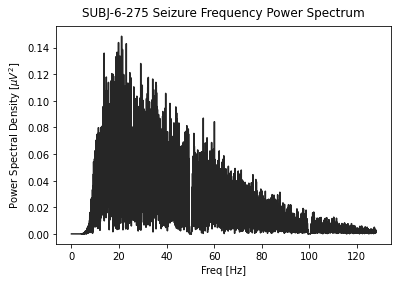

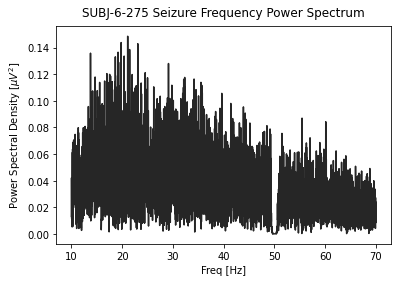

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train291_r15.npy
Current subject: train291_r15.npy


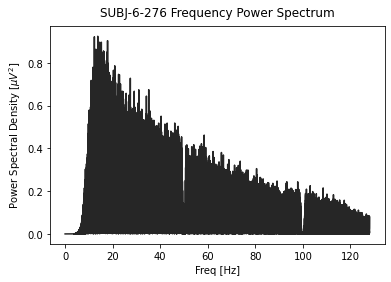

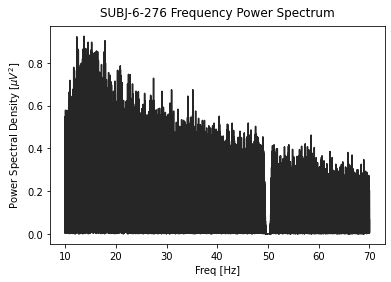

[27648]
[1409280]
[1436927]


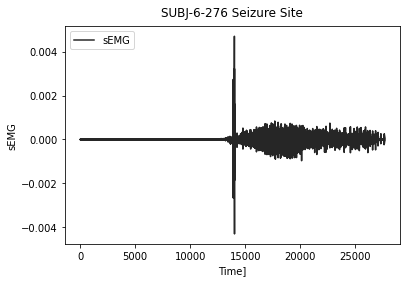

Name:  SUBJ-6-276


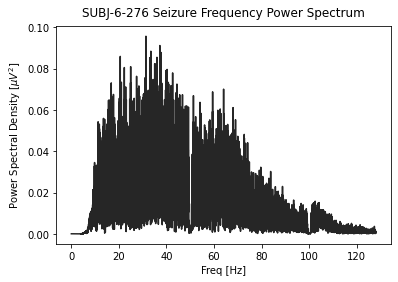

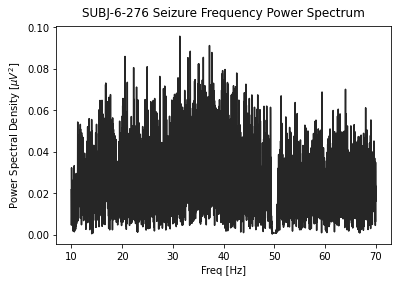

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train291_r16.npy
Current subject: train291_r16.npy


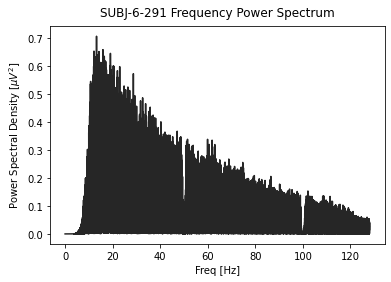

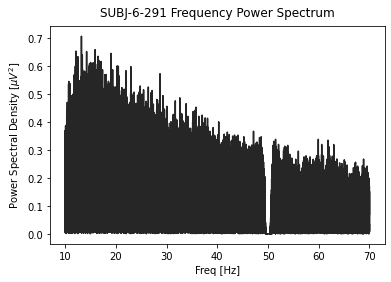

[29184]
[2337024]
[2366207]


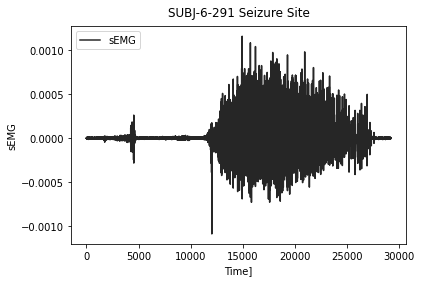

Name:  SUBJ-6-291


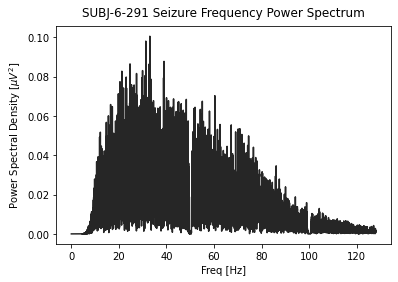

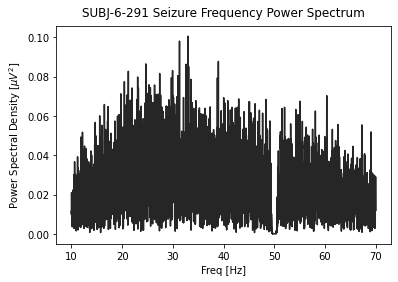

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train291_r21.npy
Current subject: train291_r21.npy


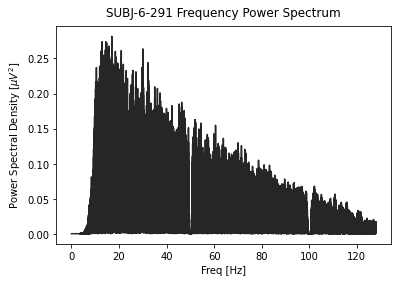

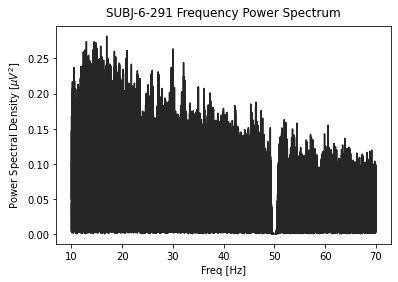

[27904]
[1751296]
[1779199]


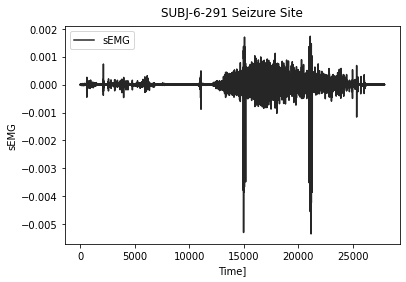

Name:  SUBJ-6-291


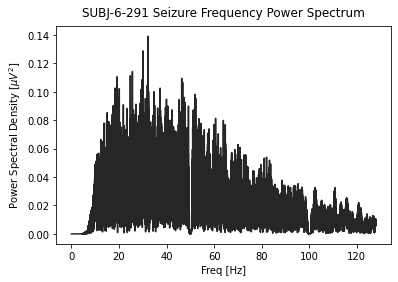

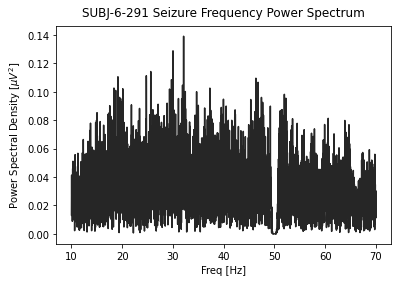

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train291_r23.npy
Current subject: train291_r23.npy


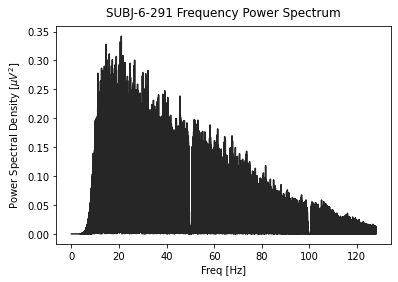

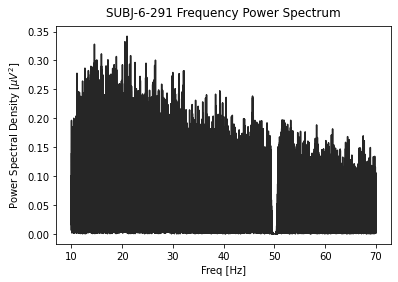

[28416]
[2396416]
[2424831]


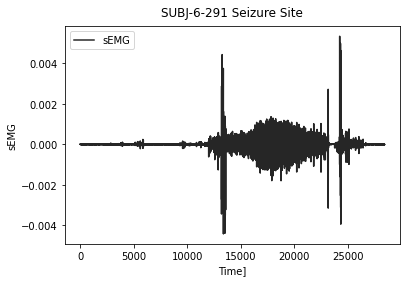

Name:  SUBJ-6-291


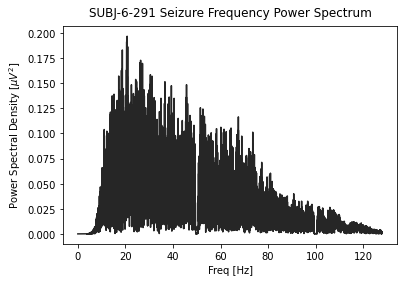

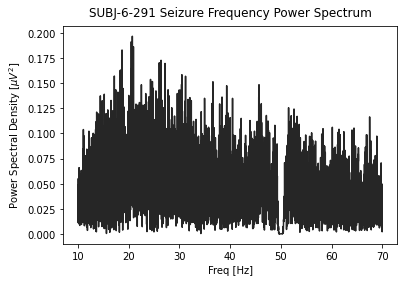

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train291_r25.npy
Current subject: train291_r25.npy


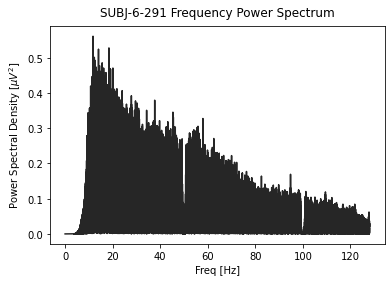

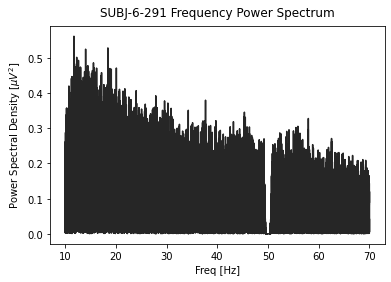

[29440]
[2163200]
[2192639]


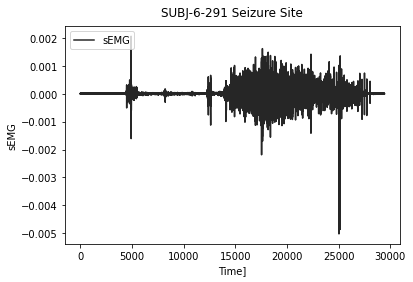

Name:  SUBJ-6-291


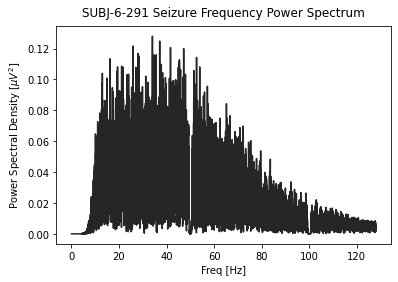

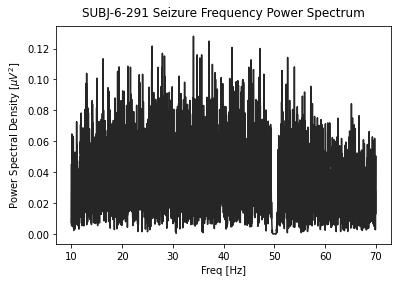

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train291_r26.npy
Current subject: train291_r26.npy


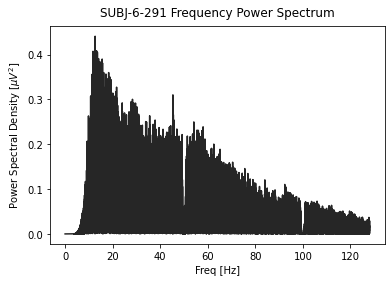

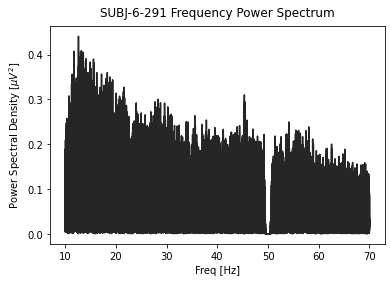

[29440]
[1932800]
[1962239]


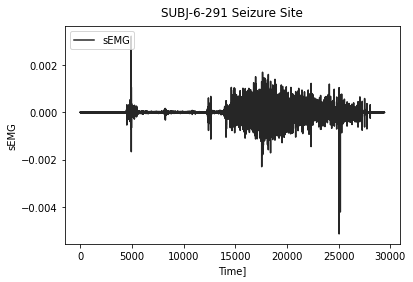

Name:  SUBJ-6-291


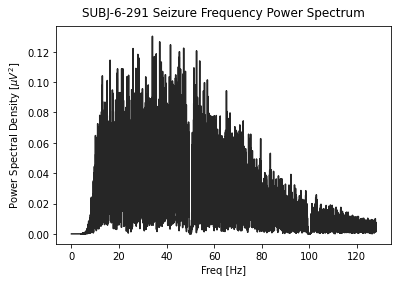

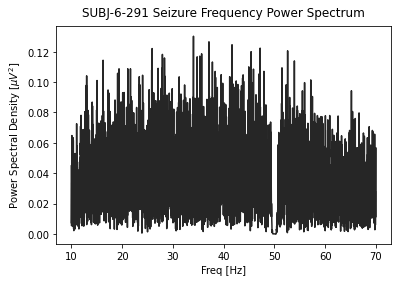

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train307_r1.npy
Current subject: train307_r1.npy


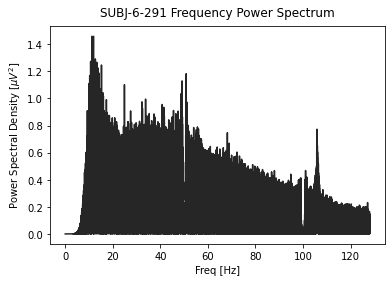

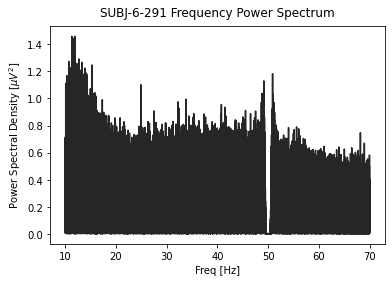

[24576, 19200]
[12789760, 14114816]
[12814335, 14134015]


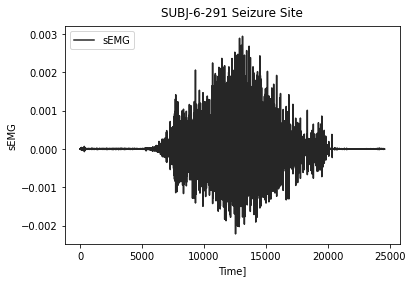

Name:  SUBJ-6-291


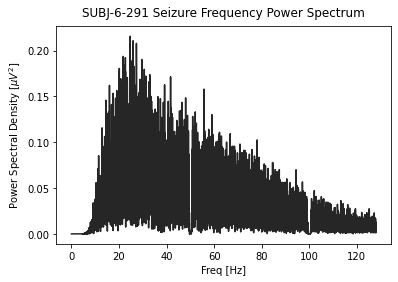

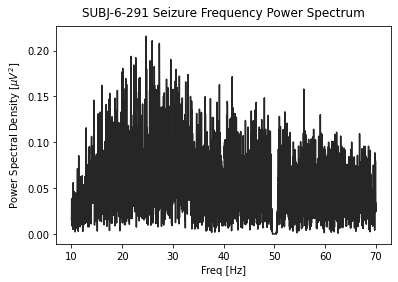

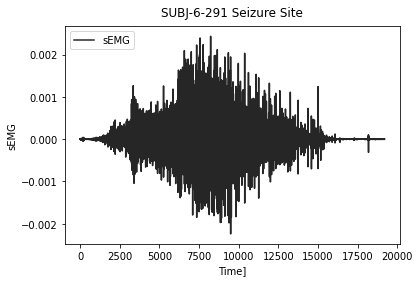

Name:  SUBJ-6-291


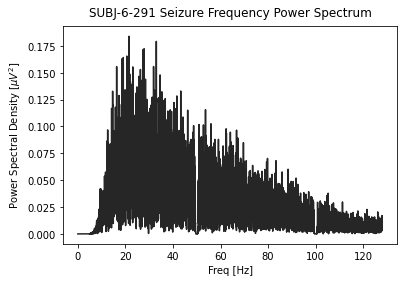

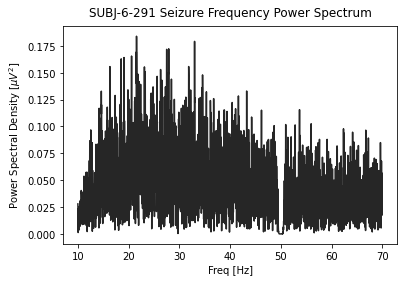

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train349_r3.npy
Current subject: train349_r3.npy


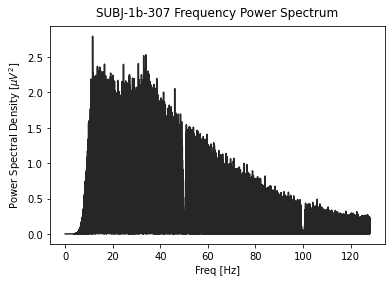

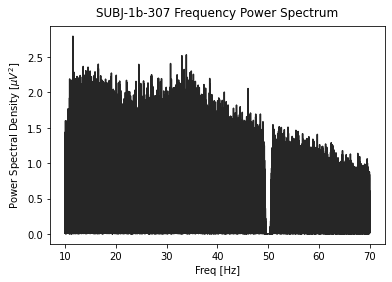

[21504]
[12214016]
[12235519]


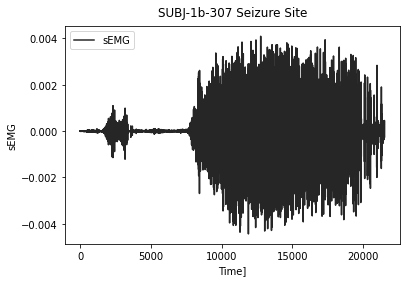

Name:  SUBJ-1b-307


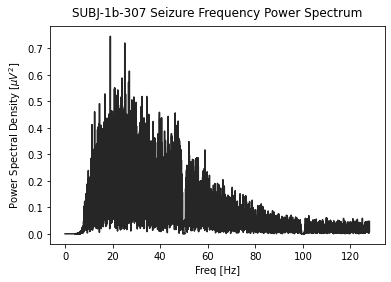

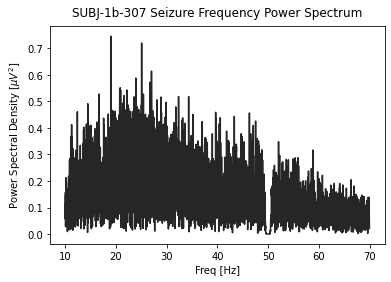

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train353_r1.npy
Current subject: train353_r1.npy


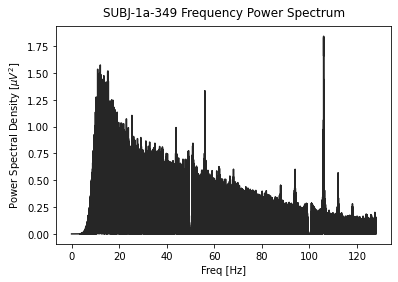

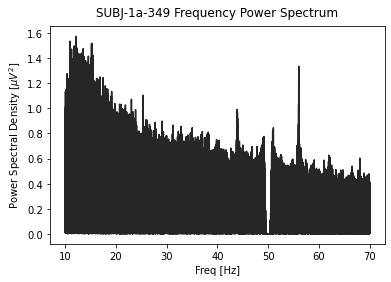

[43520]
[8731392]
[8774911]


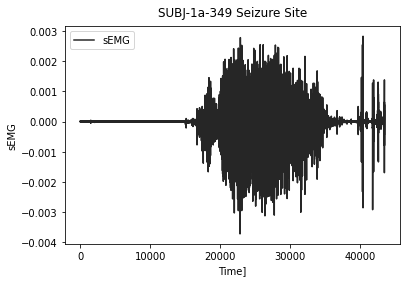

Name:  SUBJ-1a-349


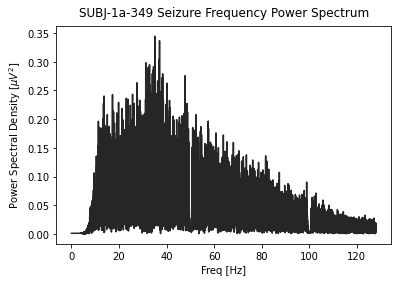

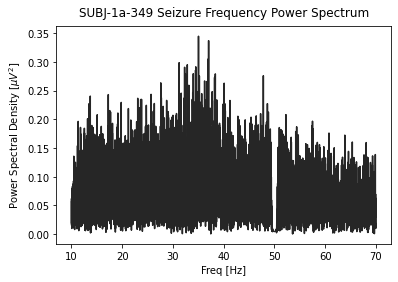

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train353_r6.npy
Current subject: train353_r6.npy


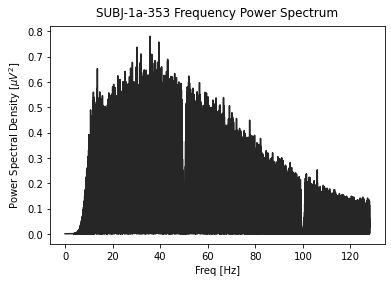

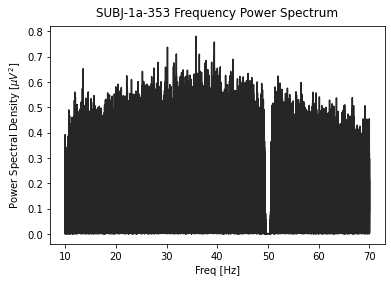

[26880]
[14788608]
[14815487]


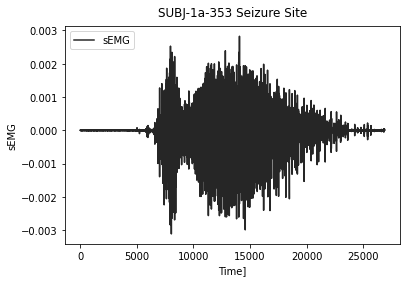

Name:  SUBJ-1a-353


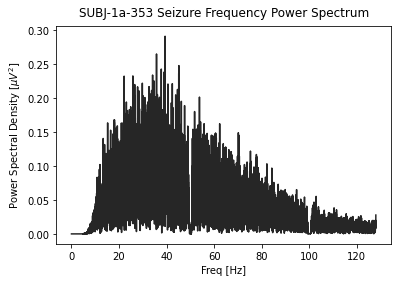

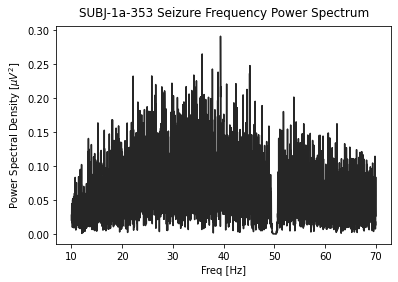

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train357_r45.npy
Current subject: train357_r45.npy


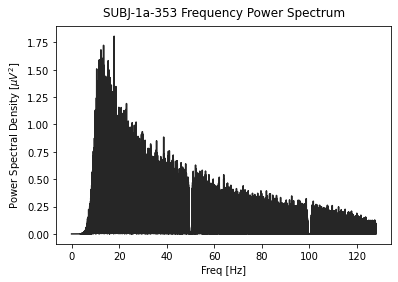

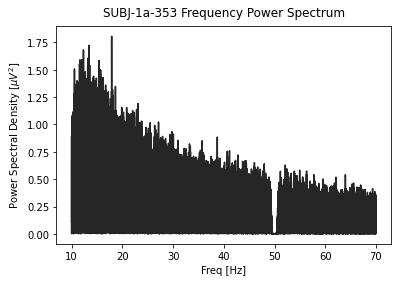

[18176]
[4141056]
[4159231]


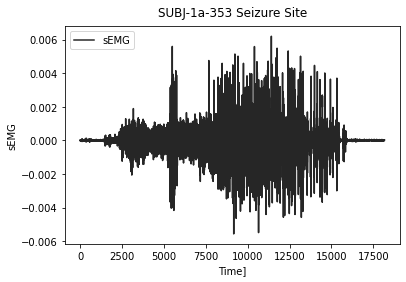

Name:  SUBJ-1a-353


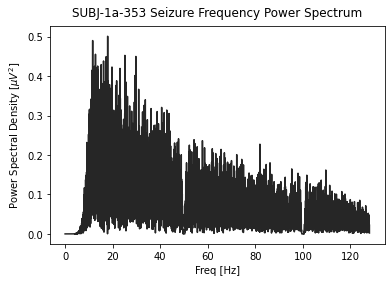

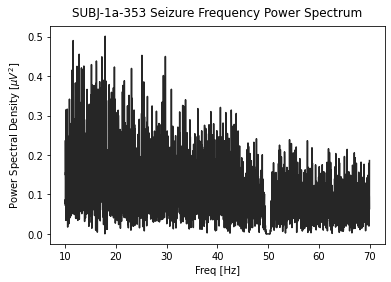

['train025_r2.npy', 'train163_r1.npy', 'train177_r4.npy', 'train178_r4.npy', 'train198_r2.npy', 'train203_r8.npy', 'train226_r6.npy', 'train256_r12.npy', 'train256_r14.npy', 'train275_r29.npy', 'train275_r31.npy', 'train276_r5.npy', 'train276_r8.npy', 'train276_r39.npy', 'train291_r15.npy', 'train291_r16.npy', 'train291_r21.npy', 'train291_r23.npy', 'train291_r25.npy', 'train291_r26.npy', 'train307_r1.npy', 'train349_r3.npy', 'train353_r1.npy', 'train353_r6.npy', 'train357_r45.npy', 'train357_r58.npy']
train357_r58.npy
Current subject: train357_r58.npy


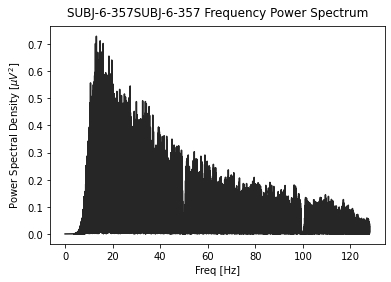

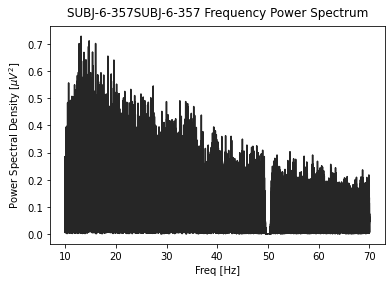

[19200]
[2606080]
[2625279]


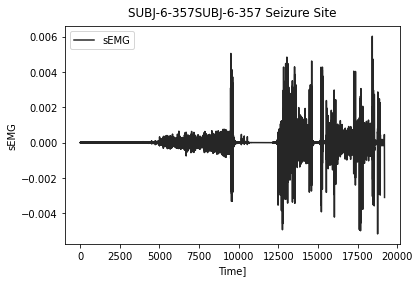

Name:  SUBJ-6-357SUBJ-6-357


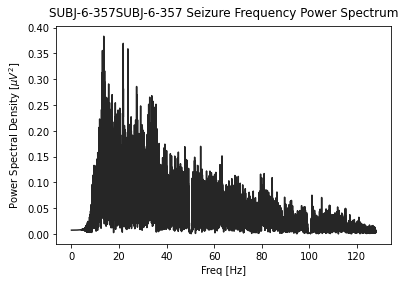

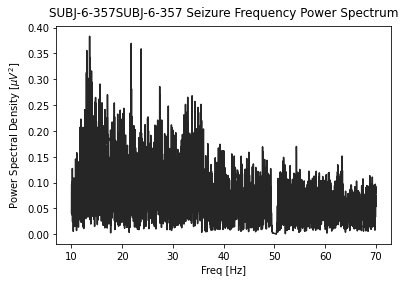

In [ ]:
for i in range(0, len(target)):
  print(target)
  print(target[i])
  test_X, test_Y= segmentor_test(target[i])
  list_len = len(test_Y)


  Fs = get_fs(target[i])
  signal_len = len(test_X)
  #signal_len = len(test_X[0:50000])


  yf = rfft(test_X)
  #yf = rfft(test_X[0:50000])
  xf = rfftfreq(signal_len, 1 / Fs)

  plt.plot(xf, abs(yf), color = 'k',alpha = 0.85)
  plt.title("{} Frequency Power Spectrum".format(names[i]), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power Spectral Density '+r'$[μV^2]$')
  #plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()

  '''
  len_freq = int(len(frq))
  first_10_percent = int(len_freq/10)
  first_50percent = int(len_freq/2)
  #end_freq = len_freq - remove_last_40
  end_freq = first_50percent - first_10_percent
  '''

  
  start_10 = np.where(xf >= 10)
  end_70 = np.where(xf <= 70)

  start_10 = int(start_10[0][0])
  end_70 = int(end_70[0][-1])


  plt.plot(xf[start_10:end_70], abs(yf[start_10:end_70]), color = 'k',alpha = 0.85)
  plt.title("{} Frequency Power Spectrum".format(names[i]), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power Spectral Density '+r'$[μV^2]$')
  #plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()


  count_real, start_real, end_real = find_seizures(test_Y, list_len)
  print(count_real)
  print(start_real)
  print(end_real)

  for j in range(0, len(count_real)):
    x_seizure_site = test_X[start_real[j]:end_real[j]]
    plt.plot(x_seizure_site, color = 'k',alpha = 0.85)
    plt.title('{} Seizure Site'.format(names[i]), pad = 10)
    plt.xlabel('Time]')
    plt.ylabel('sEMG')
    plt.legend(['sEMG'], loc = 'upper left')
    plt.show()
    Fs_2 = get_fs(target[i])
    signal_len_seizure = len(x_seizure_site)

    yf_2 = rfft(x_seizure_site)
    xf_2 = rfftfreq(signal_len_seizure, 1 / Fs)

    visualize_frequencies(xf_2, yf_2, names[i])

In [ ]:
target = all_subjects

In [ ]:
for i in range(0, len(target)):
  print(target)
  print(target[i])
  test_X, test_Y= segmentor_test(target[i])
  list_len = len(test_Y)


  Fs = get_fs(target[i])
  signal_len = len(test_X)
  #signal_len = len(test_X[0:50000])


  yf = rfft(test_X)
  #yf = rfft(test_X[0:50000])
  xf = rfftfreq(signal_len, 1 / Fs)

  plt.plot(xf, abs(yf), color = 'k',alpha = 0.85)
  plt.title("{} Frequency Power Spectrum".format(names[i]), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power')
  #plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()

  '''
  len_freq = int(len(frq))
  first_10_percent = int(len_freq/10)
  first_50percent = int(len_freq/2)
  #end_freq = len_freq - remove_last_40
  end_freq = first_50percent - first_10_percent
  '''

  
  start_10 = np.where(xf >= 10)
  end_70 = np.where(xf <= 70)

  start_10 = int(start_10[0][0])
  end_70 = int(end_70[0][-1])


  plt.plot(xf[start_10:end_70], abs(yf[start_10:end_70]), color = 'k',alpha = 0.85)
  plt.title("{} Frequency Power Spectrum".format(names[i]), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power)')
  #plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()


  count_real, start_real, end_real = find_seizures(test_Y, list_len)
  print(count_real)
  print(start_real)
  print(end_real)

  for j in range(0, len(count_real)):
    x_seizure_site = test_X[start_real[j]:end_real[j]]
    plt.plot(x_seizure_site, color = 'k',alpha = 0.85)
    plt.title('{} Seizure site'.format(names[i]), pad = 10)
    plt.xlabel('Time]')
    plt.ylabel('sEMG')
    plt.legend(['sEMG'], loc = 'upper left')
    plt.show()
    Fs_2 = get_fs(target[i])
    signal_len_seizure = len(x_seizure_site)

    yf_2 = rfft(x_seizure_site)
    xf_2 = rfftfreq(signal_len_seizure, 1 / Fs)

    visualize_frequencies(xf_2, yf_2, names[i])

In [ ]:
for i in range(0, len(target)):
  print(target)
  print(target[i])
  test_X, test_Y= segmentor_test(target[i])
  list_len = len(test_Y)


  Fs = get_fs(target[i])
  signal_len = len(test_X)
  k = np.arange(signal_len)
  print(k)
  T = signal_len/Fs
  frq = k/T 
  frq= frq[:len(frq)//2]
  Y = np.fft.fft(test_X)/signal_len
  Y = Y[:signal_len//2]

  print("Ylen: ", len(Y))
  print("Freqlen: ", len(frq))

  '''Fs_whole = get_fs(target[i])
  signal_len_whole = len(test_X)
  k_whole = np.arange(signal_len_whole)
  T_whole = signal_len_whole/Fs_whole
  frq_whole = k_whole/T_whole
  frq_whole= frq_whole[:len(frq_whole)//2]
  Y_whole = np.fft.fft(test_X)/signal_len_whole
  Y_whole = Y[:signal_len_whole//2]'''
  '''
  print("Ylen: ", len(Y_whole))
  print("Freqlen: ", len(frq_whole))
  '''

  plt.plot(frq, abs(Y), color = 'k',alpha = 0.85)
  plt.title("{} Full Spectrum".format(names[i]), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Y(freq)')
  plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()


  len_freq = int(len(frq))
  first_10_percent = int(len_freq/10)
  first_50percent = int(len_freq/2)
  #end_freq = len_freq - remove_last_40
  end_freq = first_50percent - first_10_percent

  plt.plot(frq[first_10_percent:end_freq], abs(Y[first_10_percent:end_freq]), color = 'k',alpha = 0.85)
  plt.title("{} Full Spectrum ".format(names[i]), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Y(freq)')
  plt.legend(['Freq Spectrum 1'], loc='upper left')
  plt.show()


  count_real, start_real, end_real = find_seizures(test_Y, list_len)
  print(count_real)
  print(start_real)
  print(end_real)

  for j in range(0, len(count_real)):
    x_seizure_site = test_X[start_real[j]:end_real[j]]
    plt.plot(x_seizure_site, color = 'k',alpha = 0.85)
    plt.title('Seizure site {}'.format(names[i]), pad = 10)
    plt.xlabel('Time]')
    plt.ylabel('sEMG')
    plt.show()
    Fs = get_fs(target[i])
    signal_len = len(x_seizure_site)
    k = np.arange(signal_len)
    print(k)
    T = signal_len/Fs
    frq = k/T 
    frq= frq[:len(frq)//2]
    Y = np.fft.fft(x_seizure_site)/signal_len
    Y = Y[:signal_len//2]

    visualize_frequencies(frq, Y, names[i])


In [ ]:
target = ['train203_r8.npy']
test_X, test_Y= segmentor_test(target)
#rows_test, columns_test = np.shape(test_X)
#test_X = test_X.reshape(rows_test, columns_test, 1)

In [ ]:
list_len = len(test_Y)
count_real, start_real, end_real = find_seizures(test_Y, list_len)

In [ ]:
print(count_real)
print(start_real)
print(end_real)

In [ ]:
x_seizure_site = test_X[start_real[0]:end_real[0]]

In [ ]:
plt.plot(x_seizure_site)

In [ ]:
Fs = 250
signal_len = len(x_seizure_site)
k = np.arange(signal_len)
print(k)
T = signal_len/Fs
frq = k/T 
frq= frq[:len(frq)//2]
Y = np.fft.fft(x_seizure_site)/signal_len
Y = Y[:signal_len//2]



In [ ]:
print(frq)
print(len(frq))

print(abs(Y))
print(len(abs(Y)))

In [ ]:
plt.plot(frq, abs(Y))
plt.xlabel('Freq [Hz]')
plt.ylabel('Y(freq)')

In [ ]:
print(max(frq[1000:11124]))
print(max(abs(Y[1000:11124])))

In [ ]:
print(max(frq[1000:7000]))

In [ ]:
plt.plot(frq[1000:7000], abs(Y[1000:7000]))
plt.xlabel('Freq [Hz]')
plt.ylabel('Y(freq)')